# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import pickle
import numpy as np
import csv
import matplotlib.pyplot as plt
import random
import os
from scipy import misc
import cv2
%matplotlib inline

In [2]:
# Load pickled data

#print out up to 3 decimal places
np.set_printoptions(precision=3) 

training_file = './traffic-signs-data/train.p'
validation_file='./traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_orig, y_train_orig = train['features'], train['labels']
X_valid_orig, y_valid_orig = valid['features'], valid['labels']
X_test_orig, y_test_orig = test['features'], test['labels']



---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:

# Number of training examples
n_train = X_train_orig.shape[0]

# Number of validation examples
n_validation = X_valid_orig.shape[0]

# Number of testing examples.
n_test = X_test_orig.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train_orig.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train_orig))


print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 



In [4]:

def get_titles():
    sign_titles = []
    with open('signnames.csv', 'rt', encoding='utf8') as f:
        sign_names = csv.reader(f, delimiter=',')
        for i, row in enumerate(sign_names):
            if i != 0:
                sign_titles.append(row[1])
    return sign_titles

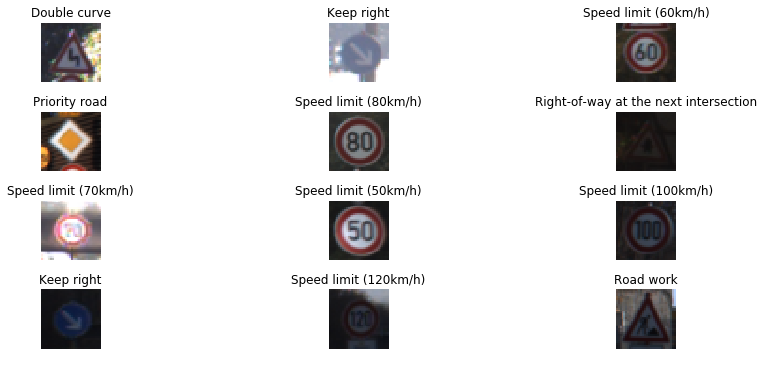

In [5]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.

# show image of 12 random data points
fig, axs = plt.subplots(4,3, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.1)
axs = axs.ravel()


titles = get_titles()

for i in range(0,12):
    index = random.randint(0, len(X_train_orig))
    image = X_train_orig[index].squeeze()
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(titles[y_train_orig[index]])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

#### Define Optimization Functions

In [6]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from math import ceil
from sklearn.utils import shuffle

def convert_to_gray(X):
    # Convert to grayscale
    X_rgb = X
    X_gray = np.sum(X/3, axis=3, keepdims=True)
    return X_gray


In [7]:
def normalize_input(X):
    return (X - 128)/128

In [8]:
def augment_brightness(imgArray):
    retArr = {}
    i = 0
    for img in imgArray:
        retImg = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        retImg = np.array( retImg, dtype = np.float64)
        random_bright = .5+np.random.uniform()
        retImg[:,:,2] =  retImg[:,:,2]*random_bright
        retImg[:,:,2][ retImg[:,:,2]>255]  = 255
        retImg = np.array( retImg, dtype = np.uint8)
        retImg = cv2.cvtColor( retImg,cv2.COLOR_HSV2RGB)
        retArr[i] = retImg
        i=i+1
    return imgArray

In [9]:
#Apply All preprocessing steps here
def preprocess_data(X):
    retVal = augment_brightness(X)
    retVal = convert_to_gray(retVal)
    retVal = normalize_input(retVal)
    return retVal

#### Apply Optimizations

In [10]:

X_train = preprocess_data(X_train_orig)
y_train = y_train_orig

X_valid = preprocess_data(X_valid_orig)
y_valid = y_valid_orig

X_test =  preprocess_data(X_test_orig)
y_test = y_test_orig

NUM_COLOR_CHANNELS = X_test.shape[3]
NUM_OUTPUT_CLASSES = 43


# Model Architecture
### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [11]:
# Define your architecture here.
### Feel free to use as many code cells as needed.

from tensorflow.contrib.layers import flatten




def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5,NUM_COLOR_CHANNELS , 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)
    #conv1 = tf.nn.tanh(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)
    #conv2 = tf.nn.tanh(conv2)
    
    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    #fc1 = tf.tanh(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    #fc2 = tf.tanh(fc2)
    
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, NUM_OUTPUT_CLASSES), mean = mu, stddev = sigma))
    # fc3_b  = tf.Variable(tf.zeros(10))
    fc3_b  = tf.Variable(tf.zeros(NUM_OUTPUT_CLASSES))
    #EBH dropout
    hidden_layer = tf.nn.dropout(fc2, keep_prob)
    logits = tf.matmul(hidden_layer, fc3_W) + fc3_b
    #conv1 = tf.add(tf.matmul(hidden_layer, weights[1]), biases[1])
      
    #logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

## Features and Labels

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.


In [12]:
x = tf.placeholder(tf.float32, (None, 32, 32, NUM_COLOR_CHANNELS))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, NUM_OUTPUT_CLASSES)

## Training Pipeline
Create a training pipeline that uses the model to classify data.

In [13]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

In [14]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model

In [15]:
# Training Parameters
EPOCHS = 25
BATCH_SIZE = 128

In [30]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
       
    saver.save(sess, './traff_sign_classifier')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.700

EPOCH 2 ...
Validation Accuracy = 0.845

EPOCH 3 ...
Validation Accuracy = 0.896

EPOCH 4 ...
Validation Accuracy = 0.905

EPOCH 5 ...
Validation Accuracy = 0.910

EPOCH 6 ...
Validation Accuracy = 0.923

EPOCH 7 ...
Validation Accuracy = 0.926

EPOCH 8 ...
Validation Accuracy = 0.935

EPOCH 9 ...
Validation Accuracy = 0.926

EPOCH 10 ...
Validation Accuracy = 0.930

EPOCH 11 ...
Validation Accuracy = 0.938

EPOCH 12 ...
Validation Accuracy = 0.935

EPOCH 13 ...
Validation Accuracy = 0.939

EPOCH 14 ...
Validation Accuracy = 0.931

EPOCH 15 ...
Validation Accuracy = 0.938

EPOCH 16 ...
Validation Accuracy = 0.948

EPOCH 17 ...
Validation Accuracy = 0.947

EPOCH 18 ...
Validation Accuracy = 0.943

EPOCH 19 ...
Validation Accuracy = 0.951

EPOCH 20 ...
Validation Accuracy = 0.945

EPOCH 21 ...
Validation Accuracy = 0.947

EPOCH 22 ...
Validation Accuracy = 0.946

EPOCH 23 ...
Validation Accuracy = 0.948

EPOCH 24 ...
Validation Accura

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './traff_sign_classifier')
    X_test, y_test = shuffle(X_test, y_test)
    test_accuracy = evaluate(X_test, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))

Test Set Accuracy = 0.932


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

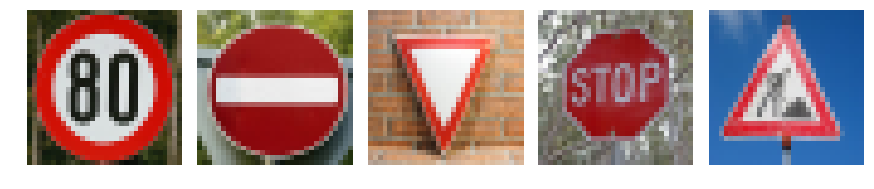

In [28]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

path = './my_new_images/'
fig, axis = plt.subplots(1,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.1)

i = 0
my_x_test_orig = np.zeros((5,32,32,3),np.float32)

for fname in os.listdir(path):
        img = misc.imread(path + fname)
        axis[i].axis('off')
        axis[i].imshow(img)
        my_x_test_orig[i] = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        i = i + 1

        


In [29]:
#Load the sign types into an array
my_y_test = np.zeros(5)
# 1st sample is speed limit 80km/hr
# 2nd sample is no entry
# 3rd sample is yield
# 4th sample is stop
# 5th sample is road work
my_y_test[0] = int(5)
my_y_test[1] = 17
my_y_test[2] = 13
my_y_test[3] = 14
my_y_test[4] = 25 


### Predict the Sign Type for Each Image

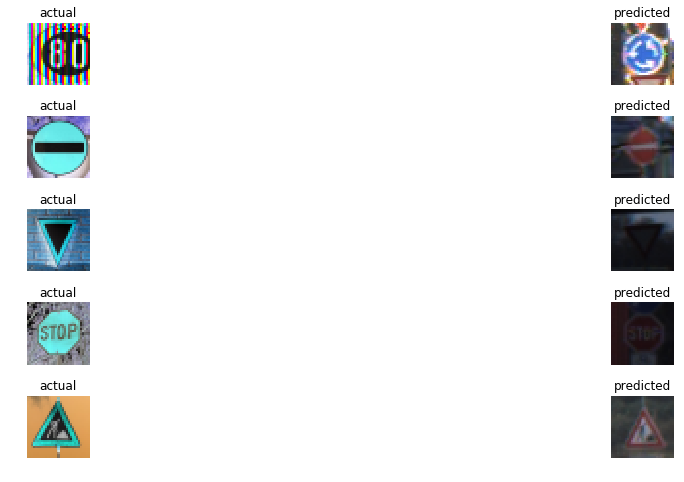

In [43]:

#Choose a random image from the test set and display results x nn forecast
#Single random evaluation:
def singleEval(X_single):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph('./traff_sign_classifier.meta')
        saver.restore(sess, './traff_sign_classifier')
        choice = sess.run(tf.argmax(logits, 1), feed_dict={x: X_single,keep_prob: 1.0})        
        return choice
### Run the predictions here and use the model to output the prediction for each image.

#APPLY PREPROCESSING
if(NUM_COLOR_CHANNELS == 1):
    my_x_test = preprocess_data(my_x_test_orig)

    
pred = singleEval(my_x_test)

num_correct = 5


fig, axis = plt.subplots(5,2, figsize=(20, 8))
fig.subplots_adjust(hspace = .5, wspace=.1)
axis = axis.ravel()

for i in range (0,5):
    #print(int(my_y_test[i]), pred[i],sep="\t\t")
    x_predicted = X_train_orig[y_train_orig == pred[i]]
    axis[2*i].set_title("actual")
    axis[2*i].axis('off')
    axis[2*i].imshow(cv2.cvtColor(my_x_test_orig[i],cv2.COLOR_RGB2BGR))
    axis[2*i+1].set_title("predicted")
    axis[2*i+1].axis('off')
    axis[2*i+1].imshow(x_predicted[0, :, :, :])
    if(pred[i] != my_y_test[i]):
        num_correct = num_correct - 1


### Analyze Performance

In [37]:
### Calculate the accuracy for these 5 new images. 
print("model's accuracy for new images:",(num_correct/5)*100,"%")

model's accuracy for new images: 80.0 %


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions
 



In [41]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
### Visualize the softmax probabilities here.
   
def test_net(x_data, sess): 
    k = 5
    prob = sess.run(tf.nn.softmax(logits), feed_dict={x: x_data, keep_prob: 1.0})    
    top5 = tf.nn.top_k(prob, k)
    return sess.run(top5)


with tf.Session() as sess:
    saver.restore(sess, './traff_sign_classifier')
    signs_top_5=test_net(my_x_test, sess)
    for i in range(5):
        print(my_y_test[i],signs_top_5[1][i],signs_top_5[0][i],sep="\t")
    


5.0	[40 28  1 11 27]	[ 0.415  0.298  0.183  0.085  0.005]
17.0	[17 14 33 13  0]	[  1.000e+00   2.169e-06   6.175e-18   8.737e-19   9.693e-20]
13.0	[13 15 35 25 26]	[  1.000e+00   4.248e-17   5.329e-19   1.181e-21   1.968e-22]
14.0	[14 38 13  1  4]	[  1.000e+00   2.068e-05   1.698e-06   6.934e-07   8.917e-08]
25.0	[25 22 29 24 18]	[  1.000e+00   1.738e-05   2.500e-06   9.957e-09   2.568e-09]


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.